In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pygad

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import trange

2023-11-07 09:59:15.854866: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 09:59:15.899300: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 09:59:15.899364: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 09:59:15.899411: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 09:59:15.908956: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 09:59:15.914345: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
data_path = "IM2S_GHS_RSS_Bloc_2019_2022_anonyme.xlsx"
df = pd.read_excel(data_path)

FileNotFoundError: [Errno 2] No such file or directory: 'IM2S_GHS_RSS_Bloc_2019_2022_anonyme.xlsx'

# Data Cleaning

In [ ]:
# Renommage des colonnes
df.rename(
    columns={
        'Date EntrÈe': 'date_entree',
        'Date Sortie': 'date_sortie',
        'Date Naissance': 'date_naissance',
        'Sexe': 'sexe',
        'CIM Diag Pr.': 'cim_diag_pr',
        'CCAM 1': 'ccam_1',
        'CCAM 2': 'ccam_2',
        'CCAM 3': 'ccam_3',
        'CCAM 4': 'ccam_4',
        'GHM Code': 'ghm_code',
        'Anesthesiste': 'anesthesiste',
        'Chirurgien': 'chirurgien',
        'AnnÈe': 'annee',
        'ID Patient': 'id_patient',
        'Date Inter': 'date_inter',
        'Nom Patient': 'nom_patient',
        "Heure entrée SSPI avant intervention (cela correspond à un SAS de pré-anesthésie). Si cette heure est la même que l'heure d'entrée en salle d'opération, cela signifie qu'il n'y as pas eu de passage en SSPI pré op": 'heure_entree_sspi',
        "Heure d'entrée en salle d'opération (calimed)": 'heure_entree_salle',
        'Heure Incision ': 'heure_incision',
        "Heure de sortie de salle d'opération (calimed)" : 'heure_sortie_salle',
        'Anesth Type' : 'anesth_type',
        'Anesth Loco_reg' : 'anesth_loco_reg',
        'DurÈe Sèjour en jour (1 pour ambu)' : 'duree_sejour',
        'Interv Type' : 'interv_type',
    },
    inplace=True
)

# Suppression des lignes non pertinentes
df = df.query("interv_type != 'Varices'")

# Suppression des lignes sans durée de séjour
df = df.query("duree_sejour < 1000")

# Conversion des dates en datetime
df['heure_entree_sspi'] = pd.to_timedelta(df['heure_entree_sspi'].astype(str))
df['heure_entree_salle'] = pd.to_timedelta(df['heure_entree_salle'].astype(str))
df['heure_incision'] = pd.to_timedelta(df['heure_incision'].astype(str))
df['heure_sortie_salle'] = pd.to_timedelta(df['heure_sortie_salle'].astype(str))

# Calcul de la durée d'opération
df['duree_sspi'] = df['heure_entree_salle'] - df['heure_entree_sspi']
df['duree_op'] = df['heure_sortie_salle'] - df['heure_entree_salle']

# Calcul de l'âge
df['age'] = df['date_entree'] - df['date_naissance']

# Ajout de la colonne urgence
df['urgence'] = df.cim_diag_pr.str.startswith('S')

# Codage des variables
df['cim_diag_pr'] = df['cim_diag_pr'].astype('category').cat.codes
df['ccam_1'] = df['ccam_1'].astype('category').cat.codes
df['ccam_2'] = df['ccam_2'].astype('category').cat.codes
df['ccam_3'] = df['ccam_3'].astype('category').cat.codes
df['ccam_4'] = df['ccam_4'].astype('category').cat.codes
df['ghm_code'] = df['ghm_code'].astype('category').cat.codes
df['anesthesiste'] = df['anesthesiste'].astype('category').cat.codes
df['chirurgien'] = df['chirurgien'].astype('category').cat.codes
df['anesth_type'] = df['anesth_type'].astype('category').cat.codes
df['anesth_loco_reg'] = df['anesth_loco_reg'].astype('category').cat.codes
df['interv_type'] = df['interv_type'].astype('category').cat.codes

# Prédiction des durées

## Analyse des données

### Influence de CIM Diag Pr. sur la durée d'opération

<AxesSubplot:xlabel='cim_diag_pr', ylabel='duree_op'>

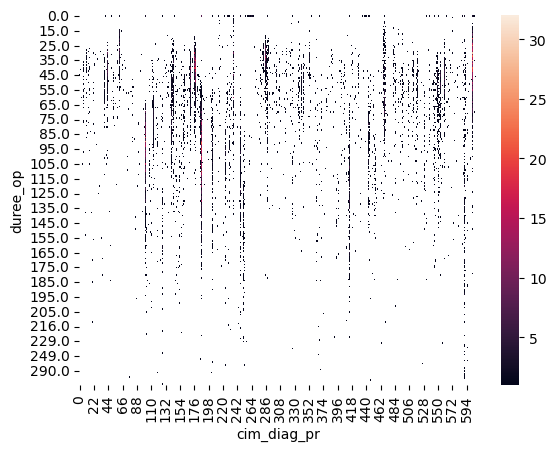

In [ ]:
df_ = pd.DataFrame({
    'cim_diag_pr': df['cim_diag_pr'].astype('int64'),
    'duree_op': (df['heure_sortie_salle'] - df['heure_entree_salle']).dt.total_seconds() // 60,
})
fig =plt.figure(figsize=(10, 5), dpi=100)
sns.heatmap(
    df_.pivot_table(index='duree_op', columns='cim_diag_pr', aggfunc=len),
)
#invert y axis 
plt.gca().invert_yaxis()

Text(0.5, 1.0, "Distribution de la durée d'opération en fonction du diagnostic principal")

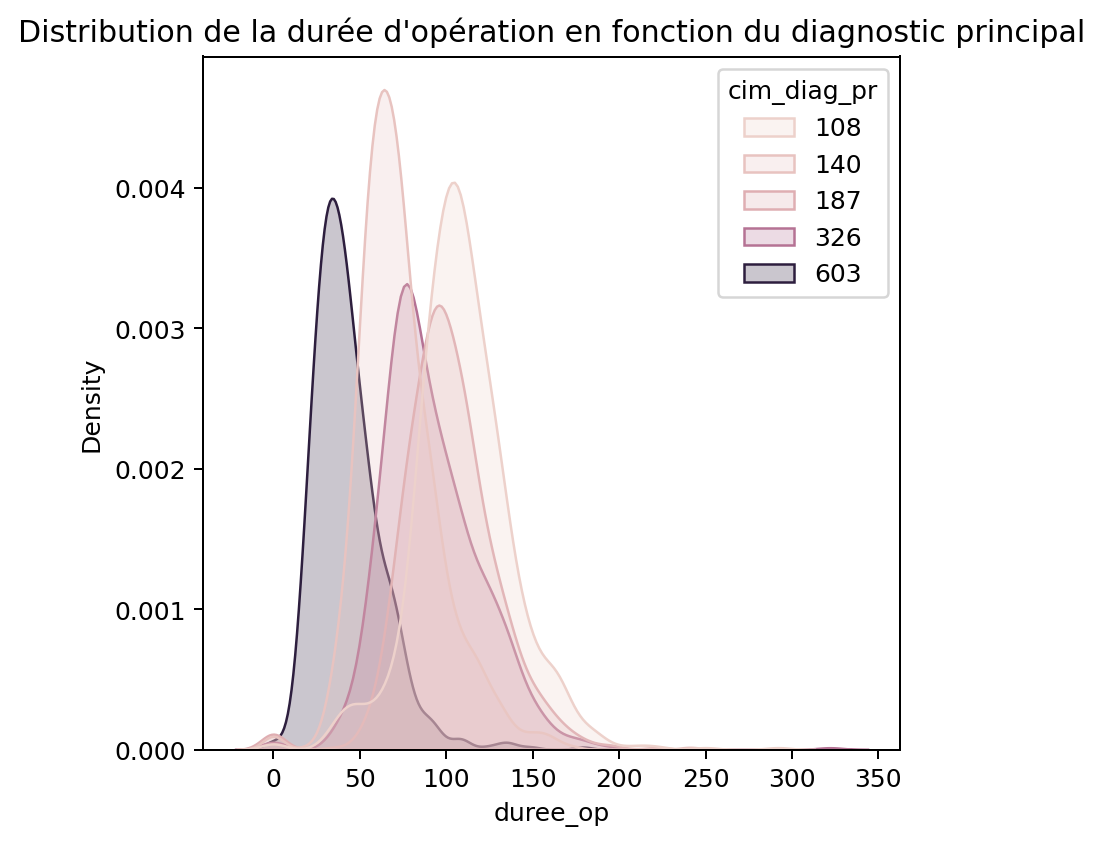

In [ ]:
df_exemple = df_.query("cim_diag_pr == [108, 603, 140, 326, 187]")

fig = plt.figure(figsize=(5, 5), dpi=180)
sns.kdeplot(
    data=df_exemple,
    x='duree_op',
    hue='cim_diag_pr',
    fill=True
) 
plt.title("Distribution de la durée d'opération en fonction du diagnostic principal")

### Préparation des features

In [ ]:
X = pd.DataFrame({
    'sexe': df['sexe'],
    'age': df['age'].dt.total_seconds() / (60 * 60 * 24 * 365),
    'cim_diag_pr': df['cim_diag_pr'],
    'ccam_1': df['ccam_1'],
    'ghm_code': df['ghm_code'],
    'anesth_type': df['anesth_type'],
    'anesth_loco_reg': df['anesth_loco_reg'],
    'interv_type': df['interv_type'],
})
y = pd.DataFrame({
    'duree_sspi': df['duree_sspi'].dt.total_seconds() / 60,
    'duree_op': df['duree_op'].dt.total_seconds() / 60,
    'duree_sejour': df['duree_sejour'],
})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
input_shape = (X.shape[1],)

### Random Forest

In [ ]:
rf = RandomForestRegressor(
    n_estimators=400,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features='sqrt',
    max_depth=20,
    bootstrap=False,
    random_state=42
)

rf.fit(X_train, y_train['duree_op'])

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=400, random_state=42)

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
rf = RandomForestRegressor()

# random search
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

rf_random.fit(X_train, y_train['duree_op'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


KeyboardInterrupt: 

In [ ]:
rf.fit(X_train, y_train['duree_op'])

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=400, random_state=42)

In [ ]:
# {'n_estimators': 400,
#  'min_samples_split': 10,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt',
#  'max_depth': 20,
#  'bootstrap': False}
# 677.5934836545263
# 0.5947134025875103

rf_random.best_params_

NameError: name 'rf_random' is not defined

In [ ]:
best_rf = rf_random.best_estimator_

NameError: name 'rf_random' is not defined

In [ ]:
# calculate the mean squared error
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test['duree_op'], y_pred)
mse

678.6674774973632

In [ ]:
rf.score(X_test, y_test['duree_op'])

0.5940710184431738

### Neural Network

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=input_shape),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='linear')
])
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy', 'mse', 'mae']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1152      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

In [ ]:
# fit model with history and calculate validation accuracy
history = model.fit(
    X_train,
    y_train,
    epochs=25,
)

Epoch 1/25
302/302 [==============================] - 1s 1ms/step - loss: 4298.6914 - accuracy: 0.6158 - mse: 4298.6914 - mae: 37.9901
Epoch 2/25
302/302 [==============================] - 0s 1ms/step - loss: 2973.6528 - accuracy: 0.7674 - mse: 2973.6528 - mae: 27.9980
Epoch 3/25
302/302 [==============================] - 0s 1ms/step - loss: 2803.1035 - accuracy: 0.8042 - mse: 2803.1035 - mae: 25.8770
Epoch 4/25
302/302 [==============================] - 0s 1ms/step - loss: 2694.6938 - accuracy: 0.8135 - mse: 2694.6938 - mae: 24.3203
Epoch 5/25
302/302 [==============================] - 0s 1ms/step - loss: 2607.1826 - accuracy: 0.8173 - mse: 2607.1826 - mae: 23.0621
Epoch 6/25
302/302 [==============================] - 0s 1ms/step - loss: 2585.4768 - accuracy: 0.8180 - mse: 2585.4768 - mae: 22.6875
Epoch 7/25
302/302 [==============================] - 0s 1ms/step - loss: 2533.0437 - accuracy: 0.8201 - mse: 2533.0437 - mae: 21.9934
Epoch 8/25
302/302 [==============================] - 0

In [ ]:
model.evaluate(X_test, y_test)

101/101 [==============================] - 0s 807us/step - loss: 2505.8533 - accuracy: 0.8279 - mse: 2505.8533 - mae: 23.3387


[2505.853271484375, 0.827886700630188, 2505.853271484375, 23.33868980407715]

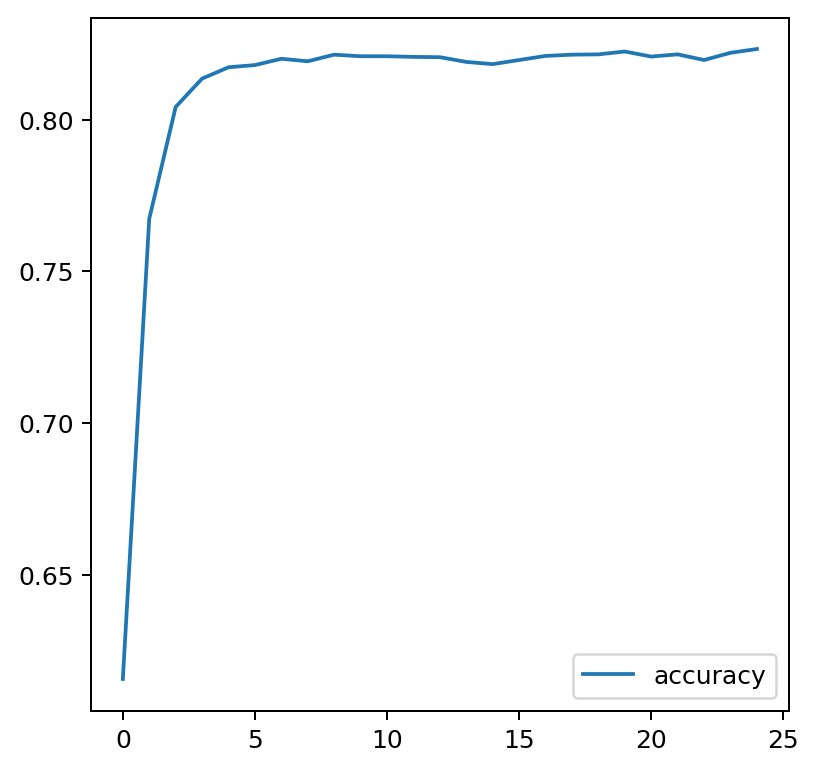

In [ ]:
fig = plt.figure(figsize=(5, 5), dpi=180)
# show the accuracy
plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label='val_mae')
plt.legend()

In [ ]:
y_pred = model.predict(X_test)
error = y_test - y_pred

error_rf = y_test['duree_op'] - y_pred_rf

# fig, axes = plt.subplots(1, 3, figsize=(25, 5))

# sns.kdeplot(data=error['duree_sspi'], fill=True, ax=axes[0])
sns.kdeplot(data=error['duree_op'], fill=True, label='Neural Network')
# sns.kdeplot(data=error['duree_sejour'], fill=True, ax=axes[2])

# sns.kdeplot(data=error['duree_sspi'], fill=True, ax=axes[0])
sns.kdeplot(data=error_rf, fill=True, label='Random Forest')
# sns.kdeplot(data=error['duree_sejour'], fill=True, ax=axes[2])

plt.title('Distribution des erreurs')
plt.legend()

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).

In [ ]:
# calculate mae
mae = mean_absolute_error(y_test['duree_op'], y_pred[:,1])
mae_rf = mean_absolute_error(y_test['duree_op'], y_pred_rf)
# calculate mse
mse = mean_squared_error(y_test['duree_op'], y_pred[:,1])
mse_rf = mean_squared_error(y_test['duree_op'], y_pred_rf)

# r2 score
r2 = r2_score(y_test['duree_op'], y_pred[:,1])
r2_rf = r2_score(y_test['duree_op'], y_pred_rf)
r2, r2_rf

(-0.7382019903643708, 0.5940710184431738)

# Prédiction des urgences

## Préparation des features

In [ ]:
df_urgences = df.query("urgence == True")

In [ ]:
X_ = df_urgences['date_entree'] + df_urgences['heure_entree_sspi']
# X_ = X_.sort_values()
# X_ = X_.astype('int64').astype('float64') / 10**18

## Visualisation des données

<AxesSubplot:ylabel='Count'>

<Figure size 2700x900 with 0 Axes>

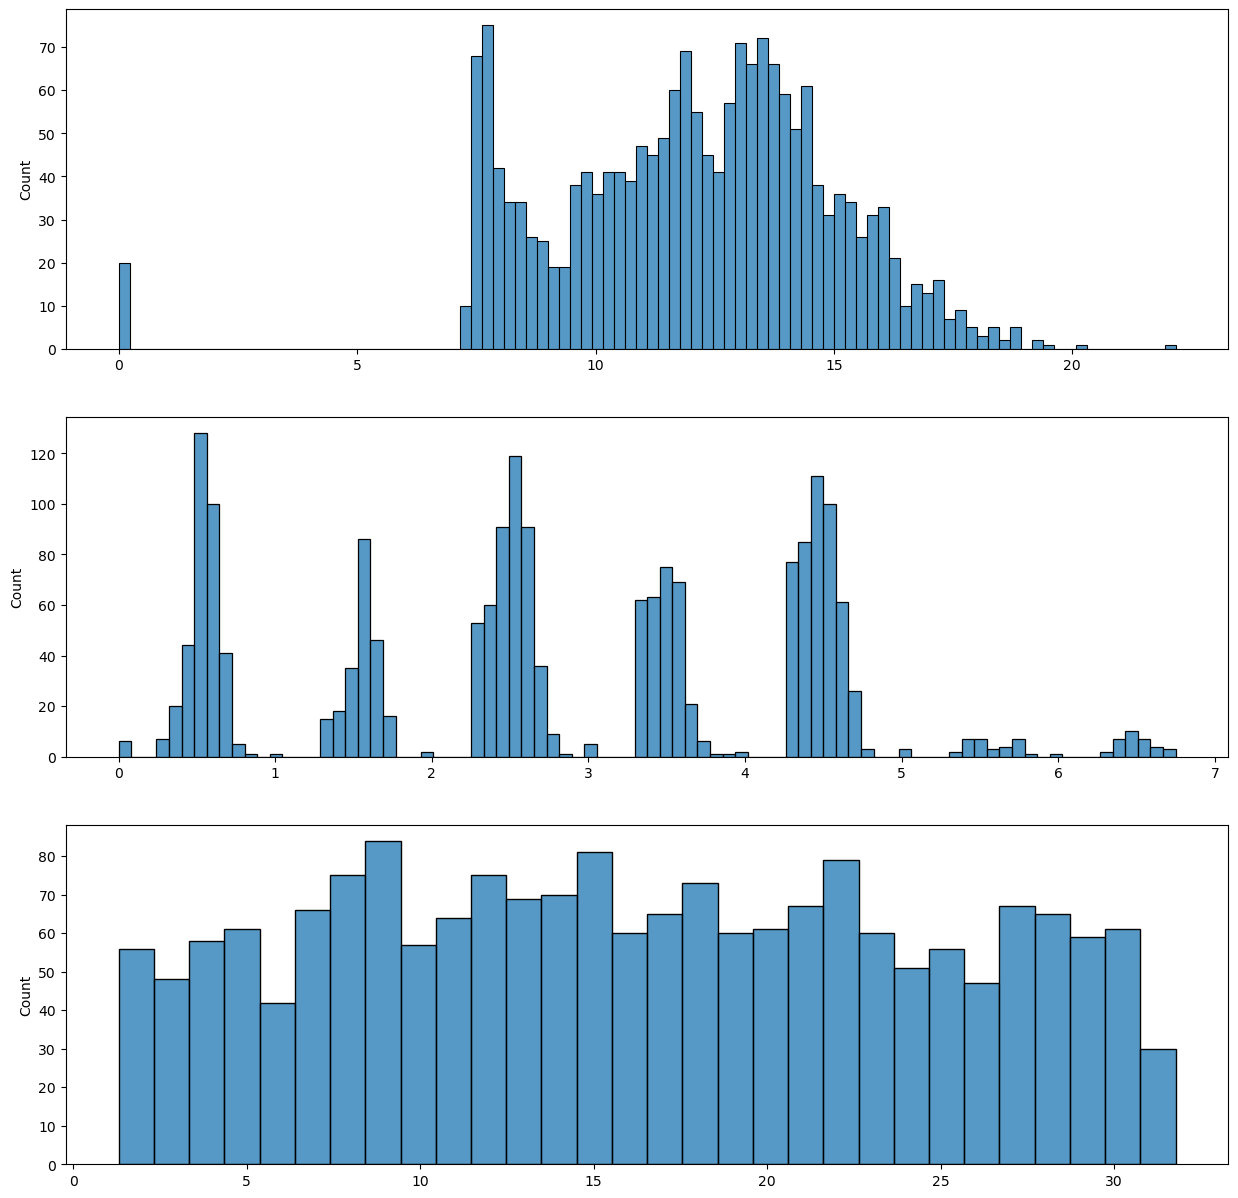

<Figure size 1500x500 with 0 Axes>

In [ ]:
time_of_day = X_.dt.hour + X_.dt.minute / 60
time_of_week = X_.dt.day_of_week + time_of_day / 24
day_of_month = X_.dt.day + time_of_day / 24
week_of_year = X_.dt.dayofyear / 7 + time_of_day / 24


fig, axes = plt.subplots(3, 1, figsize=(15, 15))
plt.figure(figsize=(15, 5))
sns.histplot(data=time_of_day, bins=24*4, label='Time of day', ax=axes[0])
sns.histplot(data=time_of_week, bins=7*12, label='Time of week',ax=axes[1])
sns.histplot(data=day_of_month, bins=30, label='Day of month', ax=axes[2])


Text(0, 0.5, 'Day of week')

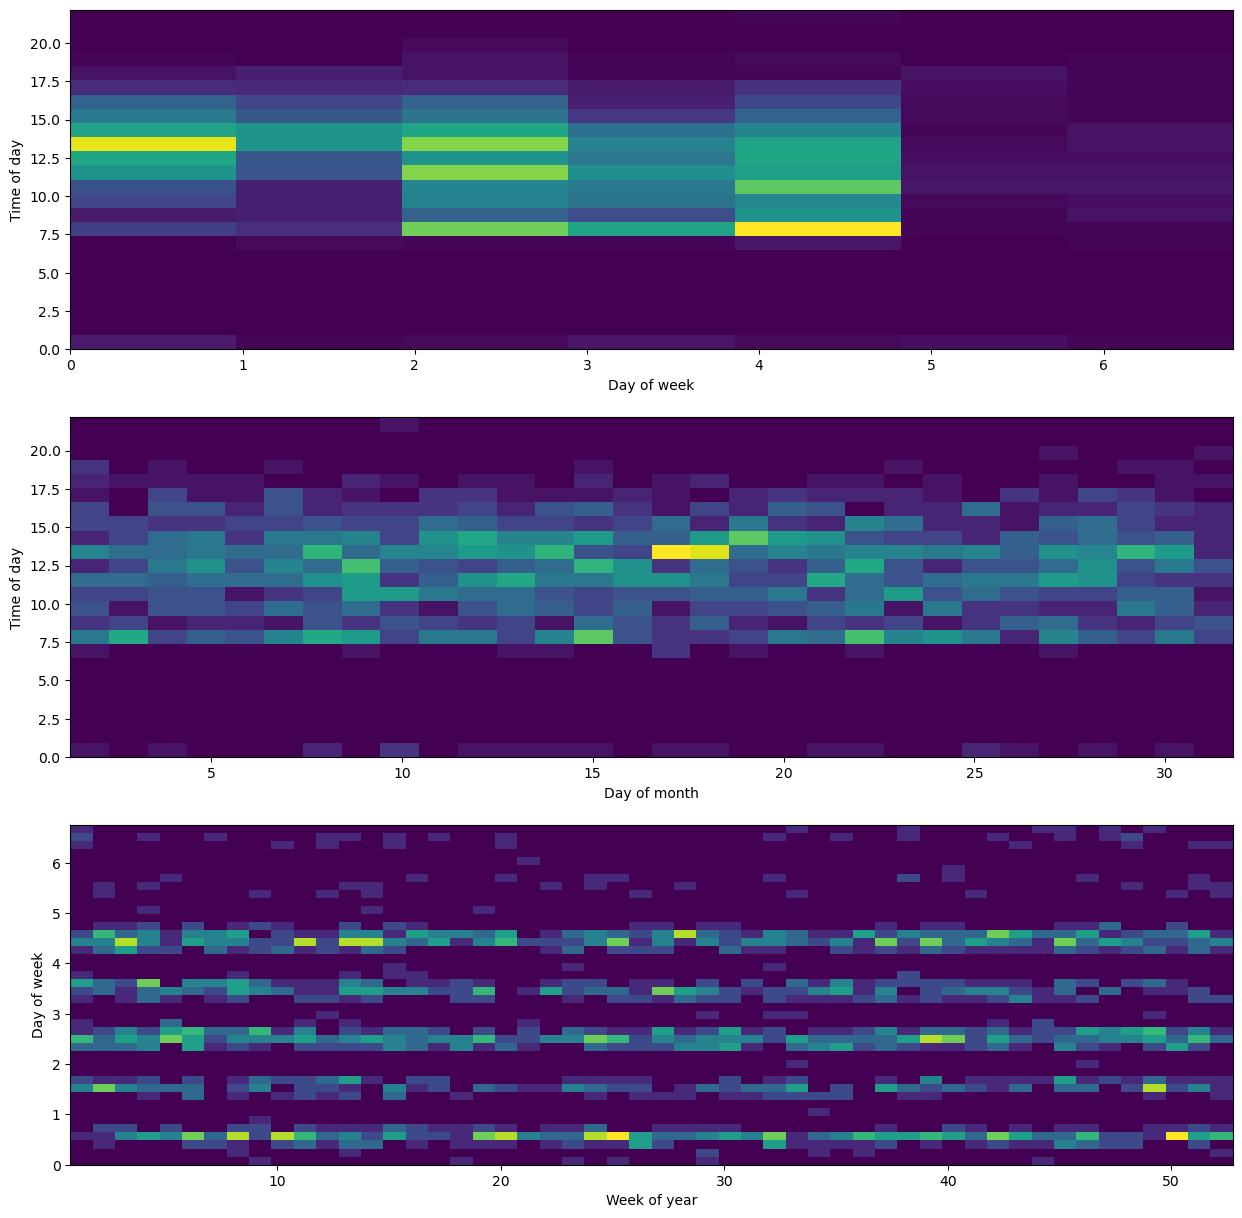

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].hist2d(time_of_week, time_of_day, bins=(7, 24))
axes[0].set_xlabel('Day of week')
axes[0].set_ylabel('Time of day')

axes[1].hist2d(day_of_month, time_of_day, bins=(30, 24))
axes[1].set_xlabel('Day of month')
axes[1].set_ylabel('Time of day')

axes[2].hist2d(week_of_year, time_of_week, bins=(52, 7*6))
axes[2].set_xlabel('Week of year')
axes[2].set_ylabel('Day of week')

## Modèles

In [ ]:
df_ts = pd.DataFrame({
    "index": X_.sort_values(),
    "count": 1
})
df_ts.set_index('index', inplace=True)
df_ts = df_ts.resample('6H').sum() 

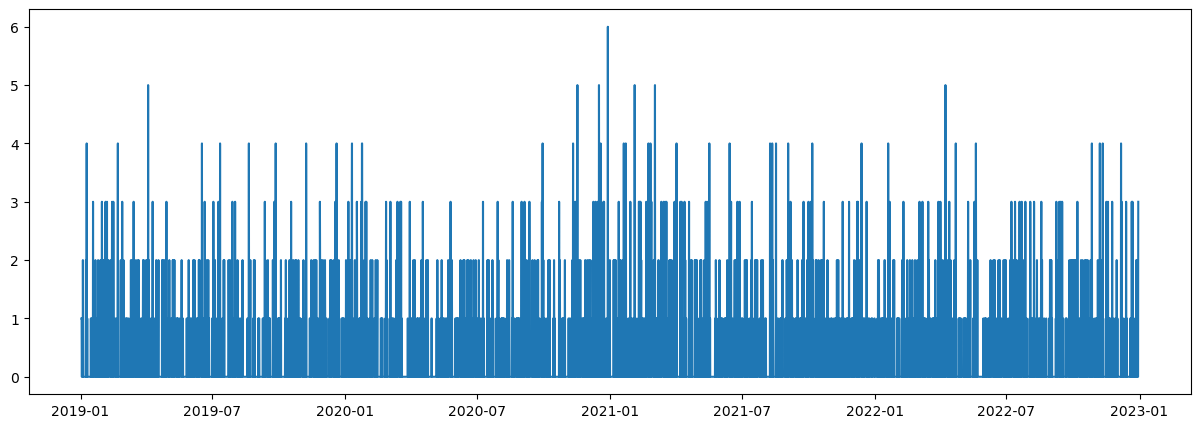

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_ts)

In [ ]:
divider = int(len(X_) * 0.8)
X_train, X_test = X_[:divider], X_[divider:]

In [ ]:
def preprocess_timeseries(X, timesteps=10):
    generator = TimeseriesGenerator(X, X.index, length=timesteps, batch_size=1)

    transformed_X = []
    for i in range(len(generator)):
        batch_X, _ = generator[i]
        transformed_X.append(batch_X)

    return np.concatenate(transformed_X, axis=0)

In [ ]:
timesteps = 10

X_ts = preprocess_timeseries(X_train, timesteps)
y_ts = np.array(X_train[timesteps:])

X_ts_test = preprocess_timeseries(X_test, timesteps)
y_ts_test = np.array(X_test[timesteps:])

In [ ]:
model = Sequential([
    LSTM(128, activation='relu', input_shape=(timesteps, 1), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy', 'mse', 'mae']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 10, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 131,537
Trainable params: 131,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    X_ts,
    y_ts,
    epochs=25,
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).

In [ ]:
y_hat = model.predict(X_ts)
y_hat_test = model.predict(X_ts_test)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).

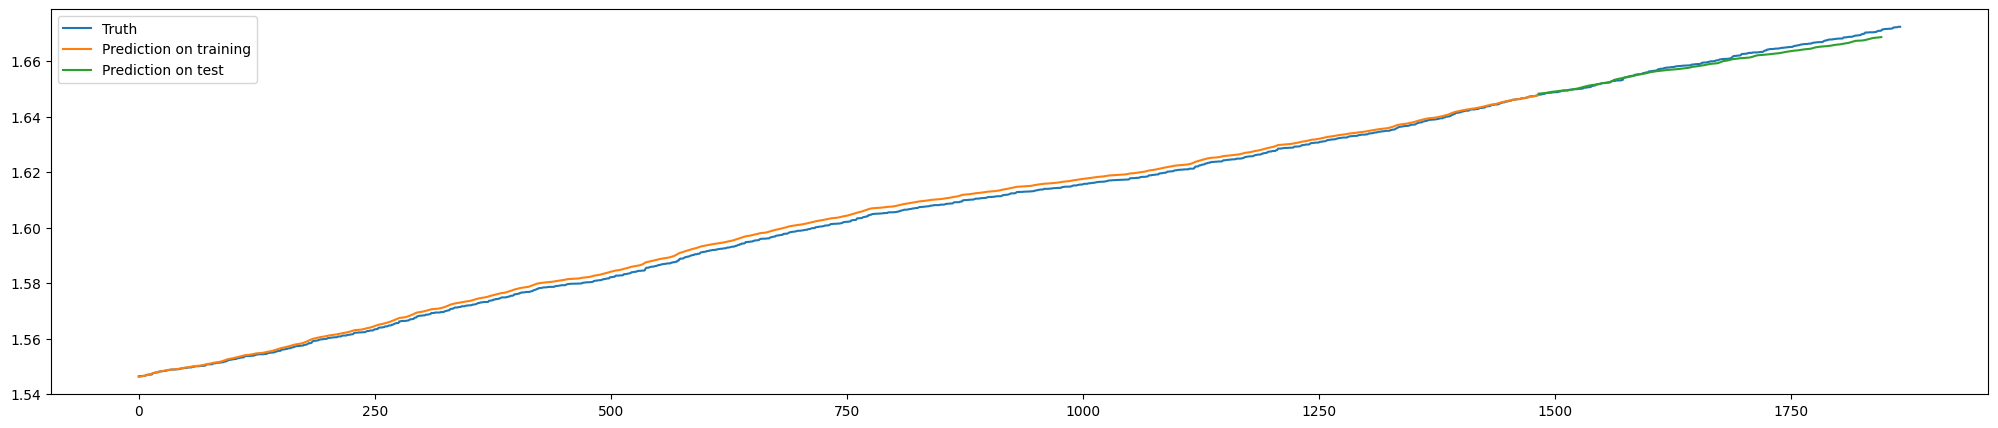

In [ ]:
fig = plt.figure(figsize=(25, 5))

plt.plot(range(len(X_)), X_, label='Truth')
plt.plot(range(len(y_ts)), y_hat, label='Prediction on training')
plt.plot(len(y_ts) + np.arange(len(y_ts_test)),y_hat_test, label='Prediction on test')

plt.legend()

# Gestion des opérations

## Tabou

In [ ]:
def calculer_cmax(ordre, temps_traitement):
    n = len(ordre)
    temps_machine = [0] * 3
    cmax = [0] * n

    for i in range(n):
        for j in range(3):
            if j == 0:
                temps_machine[j] += temps_traitement[j][ordre[i]]
            else:
                temps_machine[j] = max(temps_machine[j - 1], temps_machine[j]) + temps_traitement[j][ordre[i]]
            cmax[i] = temps_machine[j]

    return max(cmax)

In [ ]:
def mouvement_tabou(ordre, temps_traitement, tenure, tenure_length=10):
    n = len(ordre)
    meilleur_cmax = calculer_cmax(ordre, temps_traitement)
    meilleur_ordre = ordre.copy()
    mouvement_tabou = None  # Garder trace du meilleur mouvement tabou

    for i in range(n):
        for j in range(i + 1, n):
            nouveau_ordre = ordre.copy()
            nouveau_ordre[i], nouveau_ordre[j] = nouveau_ordre[j], nouveau_ordre[i]
            nouveau_cmax = calculer_cmax(nouveau_ordre, temps_traitement)

            # Vérifier si le mouvement est tabou
            if (i, j) not in tenure or nouveau_cmax < meilleur_cmax:
                if nouveau_cmax < meilleur_cmax:
                    meilleur_cmax = nouveau_cmax
                    meilleur_ordre = nouveau_ordre.copy()
                    mouvement_tabou = (i, j)  # Mettre à jour le meilleur mouvement tabou

    # Mettre à jour la liste tabou
    if mouvement_tabou:
        if len(tenure) >= tenure_length:
            tenure.pop(0)  # Retirer le plus ancien mouvement tabou
        tenure.append(mouvement_tabou)  # Ajouter le nouveau mouvement tabou

    return meilleur_ordre

In [ ]:
def tabou(flow_shop, max_iterations, tenure):
    n = len(flow_shop[0])
    ordre = list(range(n))
    meilleur_ordre = ordre.copy()
    meilleur_cmax = calculer_cmax(meilleur_ordre, flow_shop)

    for _ in range(max_iterations):
        ordre = mouvement_tabou(ordre, flow_shop, tenure)
        cmax = calculer_cmax(ordre, flow_shop)

        if cmax < meilleur_cmax:
            meilleur_cmax = cmax
            meilleur_ordre = ordre.copy()

    return meilleur_ordre, meilleur_cmax

In [ ]:
flow_shop = [
    [6, 3, 10, 14, 5, 9, 7, 11, 2, 3],
    [1, 5, 4, 6, 10, 6, 9, 8, 6, 1],
    [5, 8, 1, 3, 6, 10, 12, 9, 6, 7]
]
# Paramètres de l'algorithme
max_iterations = 1000
tenure = []
tenure_length = 100

In [ ]:
meilleur_ordre, meilleur_cmax = tabou(flow_shop, max_iterations, tenure)
print("Meilleur ordre de tâches :", meilleur_ordre)
print("Cmax optimal :", meilleur_cmax)

Meilleur ordre de tâches : [8, 1, 0, 9, 4, 5, 6, 7, 3, 2]
Cmax optimal : 75


## Données

In [ ]:
num_salles = 4
num_patients = 100
num_chiurgiens = 10

operations = pd.DataFrame({
    'index': np.arange(num_patients),
    'duree_op': np.random.randint(30*60, 300*60, size=num_patients),
    'duree_sspi': np.random.randint(5*60, 60*60, size=num_patients),
    'duree_sejour': np.random.randint(1, 10, size=num_patients),
    'urgence': np.random.random(num_patients) > 0.8,
    'chirurgien': np.random.randint(0, num_chiurgiens, size=num_patients),
    'date_entree': np.random.randint(-14*24*60, 0, size=num_patients) + 1695913686,
})

In [ ]:
operations

,index,duree_op,duree_sspi,duree_sejour,urgence,chirurgien,date_entree
0,0,6079,2190,7,False,7,1695906585
1,1,6217,2579,8,False,3,1695899152
2,2,2610,1383,6,True,9,1695911493
3,3,9535,1554,8,False,3,1695897297
4,4,9134,2889,8,False,3,1695897092
...,...,...,...,...,...,...,...
95,95,7235,1600,6,False,4,1695897000
96,96,4830,738,1,True,2,1695894685
97,97,17058,2886,6,False,5,1695894954
98,98,15928,1902,7,False,3,1695902350


## Critères

In [ ]:
def calculer_dates(planning, operations):
    dates_operations = operations.copy()
    dates_operations['salle'] = np.nan
    dates_operations['debut_op'] = np.nan
    dates_operations['fin_op'] = np.nan

    for salle in range(num_salles):
        time = 1695913686
        for operation in planning[salle]:
            dates_operations.loc[operation, 'salle'] = salle
            dates_operations.loc[operation, 'debut_op'] = time
            dates_operations.loc[operation, 'fin_op'] = time + dates_operations.loc[operation, 'duree_op']
            time += dates_operations.loc[operation, 'duree_op']
    return dates_operations

In [ ]:
# random planning
np.random.seed(42)
planning = np.random.permutation(num_patients).reshape(num_salles, -1)
planning

array([[83, 53, 70, 45, 44, 39, 22, 80, 10,  0, 18, 30, 73, 33, 90,  4,
        76, 77, 12, 31, 55, 88, 26, 42, 69],
       [15, 40, 96,  9, 72, 11, 47, 85, 28, 93,  5, 66, 65, 35, 16, 49,
        34,  7, 95, 27, 19, 81, 25, 62, 13],
       [24,  3, 17, 38,  8, 78,  6, 64, 36, 89, 56, 99, 54, 43, 50, 67,
        46, 68, 61, 97, 79, 41, 58, 48, 98],
       [57, 75, 32, 94, 59, 63, 84, 37, 29,  1, 52, 21,  2, 23, 87, 91,
        74, 86, 82, 20, 60, 71, 14, 92, 51]])

In [ ]:
calculer_dates(planning, operations)

,index,duree_op,duree_sspi,duree_sejour,urgence,chirurgien,date_entree,salle,debut_op,fin_op
0,0,6079,2190,7,False,7,1695906585,0.0,1.696041e+09,1.696047e+09
1,1,6217,2579,8,False,3,1695899152,3.0,1.696002e+09,1.696008e+09
2,2,2610,1383,6,True,9,1695911493,3.0,1.696040e+09,1.696043e+09
3,3,9535,1554,8,False,3,1695897297,2.0,1.695920e+09,1.695930e+09
4,4,9134,2889,8,False,3,1695897092,0.0,1.696113e+09,1.696122e+09
...,...,...,...,...,...,...,...,...,...,...
95,95,7235,1600,6,False,4,1695897000,1.0,1.696108e+09,1.696116e+09
96,96,4830,738,1,True,2,1695894685,1.0,1.695944e+09,1.695949e+09
97,97,17058,2886,6,False,5,1695894954,2.0,1.696088e+09,1.696105e+09
98,98,15928,1902,7,False,3,1695902350,2.0,1.696137e+09,1.696153e+09


In [ ]:
def critere_chirurgiens(planning, operations):
    dates_operations = calculer_dates(planning, operations)
            
    chirugiens = dates_operations.chirurgien.unique()
    conflicts = 0
    for chirugien in chirugiens:
        df = dates_operations.query(f"chirurgien == {chirugien}").sort_values('debut_op')
        for i in range(len(df)):
            if i > 0 and df.iloc[i]['debut_op'] > df.iloc[i - 1]['fin_op']:
                conflicts += 1
    return conflicts

In [ ]:
def critere_urgences(planning, operations):
    dates_operations = calculer_dates(planning, operations)
    urgences = dates_operations.query("urgence == True")
    conflicts = 0
    for i in range(len(urgences)):
        operation = urgences.iloc[i]
        if operation['date_entree'] + 48 * 60 < operation['debut_op']:
            conflicts += 1
    return conflicts

## Optimisation

In [ ]:
# random planning
np.random.seed(42)
planning = np.random.permutation(num_patients).reshape(num_salles, -1)

In [ ]:
df = calculer_dates(planning, operations)
df.debut_op = pd.to_datetime(df.debut_op, unit='s')
df.fin_op = pd.to_datetime(df.fin_op, unit='s')

fig = px.timeline(df, x_start="debut_op", x_end="fin_op", y="salle", color="urgence", hover_name="index")
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.show()

In [ ]:
desired_output = np.arange(num_patients)

def fitness(gad, solution, index):
    return - np.linalg.norm(solution - desired_output)

In [ ]:
fitness_function = fitness

num_generations = 5000
num_parents_mating = 8

sol_per_pop = 32
num_genes = num_patients

init_range_low = 0
init_range_high = num_patients

parent_selection_type = "sss"
keep_parents = 4

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

In [ ]:
ga_instance = pg.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_type=np.int32,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

In [ ]:
# set intial population
ga_instance.population = np.array([np.random.permutation(num_patients) for _ in range(sol_per_pop)])
ga_instance.run()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [ 0  0  0  0  0  0  0  7  0  8  6  7  1 13  9 14  3 12 14  3  0 17 20 10
 23 13 24 22 28  8 12 22 24 33 31 27 20  1 30 33 39 10 39 42  6 46 35  0
 33 31 36 48 52 40 54 53 19 54 46 52  3 52 12 59 61 11 54 33 41  0 48  8
 36 17 22 40 30 68 76 27 76 65 52 64 45 66 79 26 38 73 78 69 65 55 56 87
 84 82 63 50]
Fitness value of the best solution = -250.9362468835461


In [ ]:
# Define the parameters
num_patients = 100  # Adjust as needed
num_generations = 2000
population_size = 20

desired_output = np.arange(num_patients)

def fitness_function(gad, solution, solution_idx):
    return 1/np.linalg.norm(solution - desired_output)


# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=10,
                       fitness_func=fitness_function,
                       sol_per_pop=population_size,
                       num_genes=num_patients,
                       gene_type=np.int32,
                       mutation_type="swap",
                       )

# Initialize the population with random values between 0 and num_patients
initial_population = np.array([np.random.permutation(num_patients) for _ in range(population_size)])
ga_instance.population = initial_population

# Start the optimization process
ga_instance.run()

# Get the best solution from the final generation
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Best Solution:", solution)
print("Fitness:", solution_fitness)

Best Solution: [19 20  2 32 54 35 23  4  5 12 31  0 25 42 46 62 18 36 43 11 94  7 39  8
  6 23 30 27 50 41 56  4 82  1 77 33 59 37 21 72 34 52  0 43 64 72 56 55
 78 50 19 55 59 32 54 51 23 40 27 84 52 61 65 42 63 62 57 36 43 11 94 60
 39 71 69 23 89 98 50 49 70 61 82 83 77 67 59 37 21 72 81 52 87 93 64 83
 92 55 81 97]
Fitness: 0.004031111238076187


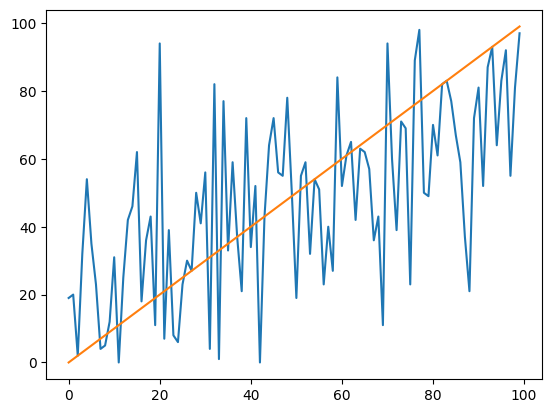

In [ ]:
plt.plot(solution)
plt.plot(desired_output)